In [3]:
!pip install sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.0 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=5938185e3c4923e20125e207d3fb66a1a60150514b026d88b5472c3cd14c623f
  Stored in directory: /root/.cache/pip/wheels/83/71/2b/40d17d21937fed496fb99145227eca8f20b4891240ff60c86f
Successfully built sentence_transformers


In [4]:
import numpy as np 
import pandas as pd
import random
import keras
import torch
import os
import tensorflow as tf
import optuna
from optuna import Trial
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from sklearn.metrics import log_loss
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
from sklearn import metrics
SEED = 99
def random_seed(SEED):
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    tf.random.set_seed(SEED)
random_seed(SEED)

In [12]:
data = pd.read_excel('/kaggle/input/all-data-cls/Cleaned_data_CLS1.xlsx')
data = data.sample(frac=1).reset_index(drop=True)
print(data.shape)
print(data['Category'].value_counts())

(413139, 2)
tamilnadu        50771
World            49219
Health&Nature    47140
Technology       44370
Business         43456
Crime            43074
Movie            42121
National         42058
Sports           41960
Spirutual         8970
Name: Category, dtype: int64


In [13]:
data.head(10)

,En_Posts,Category
0,parliament panel wants uidai adopt self sustai...,Business
1,rabridevi leader opposition upper,National
2,divakaran denied said,tamilnadu
3,asia power launches powerkey,Technology
4,covid impact oil prices fall barrel,Business
5,mayawati boycotts participation mega alliance ...,National
6,dominic thiem pulls events leading australian,Sports
7,year old raped neighbour bhopal s nishatpura,Crime
8,cbse explains neet exam controversy s personal...,National
9,stop offer special worship february,Spirutual


In [14]:
da = pd.get_dummies(data['Category'])
da['En_Posts'] = data['En_Posts']
da.head()

,Business,Crime,Health&Nature,Movie,National,Spirutual,Sports,Technology,World,tamilnadu,En_Posts
0,1,0,0,0,0,0,0,0,0,0,parliament panel wants uidai adopt self sustai...
1,0,0,0,0,1,0,0,0,0,0,rabridevi leader opposition upper
2,0,0,0,0,0,0,0,0,0,1,divakaran denied said
3,0,0,0,0,0,0,0,1,0,0,asia power launches powerkey
4,1,0,0,0,0,0,0,0,0,0,covid impact oil prices fall barrel


In [ ]:
['Business', 'Crime', 'Health&Nature', 'Movie',  'Spirutual','National', 'Sports', 'Technology', 'World', 'tamilnadu']

<AxesSubplot:>

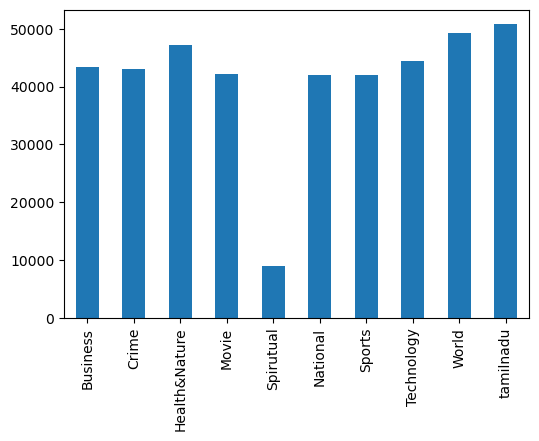

In [16]:
comments_labels = da[['Business', 'Crime', 'Health&Nature', 'Movie',  'Spirutual','National', 'Sports', 'Technology', 'World', 'tamilnadu']]
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 6
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size
comments_labels.sum(axis=0).plot.bar()

In [17]:
model = SentenceTransformer('bert-base-uncased')
model.max_seq_length = 512
print("Max Sequence Length:", model.max_seq_length)
sentence_embeddings = model.encode(da['En_Posts'])

Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Max Sequence Length: 512


Batches:   0%|          | 0/12911 [00:00<?, ?it/s]

In [18]:
train1_x, test_x, train1_y, test_y = train_test_split(sentence_embeddings, 
                                                      comments_labels, 
                                                      train_size=0.9, 
                                                      test_size=0.1, 
                                                      random_state=42)

In [25]:
model = keras.Sequential()
model.add(keras.layers.Dense(52,input_shape=(len(sentence_embeddings[0]),),activation=tf.keras.activations.swish))
model.add(keras.layers.Dropout(0.12358056857686284))
model.add(keras.layers.Dense(10,activation=tf.keras.activations.sigmoid))

In [26]:
METRICS = [ tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='Precision'),
    tf.keras.metrics.Recall(name='recall')
]
model.compile(loss='binary_crossentropy',metrics=METRICS, optimizer='Adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 52)                39988     
                                                                 
 dropout_1 (Dropout)         (None, 52)                0         
                                                                 
 dense_3 (Dense)             (None, 10)                530       
                                                                 
Total params: 40,518
Trainable params: 40,518
Non-trainable params: 0
_________________________________________________________________


In [27]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=1,min_lr=1e-05,verbose=1)
early_stoping = EarlyStopping(monitor="val_loss",min_delta=0,patience=5,verbose=1,mode="auto", baseline=None,restore_best_weights=True)
val_ds = (test_x, test_y)

In [29]:
histroy = model.fit(train1_x, train1_y, validation_data=val_ds, epochs=50,callbacks=[reduce_lr,early_stoping],verbose=1,batch_size=82)

Epoch 1/50
4535/4535 [==============================] - 23s 5ms/step - loss: 0.1129 - accuracy: 0.7781 - Precision: 0.8449 - recall: 0.7109 - val_loss: 0.1066 - val_accuracy: 0.7873 - val_Precision: 0.8585 - val_recall: 0.7126 - lr: 0.0010
Epoch 2/50
4535/4535 [==============================] - 21s 5ms/step - loss: 0.1094 - accuracy: 0.7850 - Precision: 0.8497 - recall: 0.7205 - val_loss: 0.1045 - val_accuracy: 0.7905 - val_Precision: 0.8592 - val_recall: 0.7219 - lr: 0.0010
Epoch 3/50
4535/4535 [==============================] - 23s 5ms/step - loss: 0.1073 - accuracy: 0.7897 - Precision: 0.8531 - recall: 0.7252 - val_loss: 0.1035 - val_accuracy: 0.7927 - val_Precision: 0.8669 - val_recall: 0.7193 - lr: 0.0010
Epoch 4/50
4535/4535 [==============================] - 22s 5ms/step - loss: 0.1058 - accuracy: 0.7920 - Precision: 0.8559 - recall: 0.7284 - val_loss: 0.1014 - val_accuracy: 0.7973 - val_Precision: 0.8673 - val_recall: 0.7291 - lr: 0.0010
Epoch 5/50
4530/4535 [==================

In [30]:
y_predicted = model.predict(test_x)

1292/1292 [==============================] - 2s 2ms/step


In [32]:
y_predicted

array([[1.5800986e-04, 9.6823800e-01, 5.3243381e-03, ..., 2.0968226e-04,
        9.4248410e-03, 2.6314503e-02],
       [1.2015125e-02, 8.1517980e-02, 1.0465600e-02, ..., 4.3072356e-03,
        2.6330158e-02, 4.2275876e-02],
       [1.0531261e-04, 7.3634472e-04, 3.8810036e-04, ..., 1.5045116e-04,
        9.9027365e-01, 8.3329687e-03],
       ...,
       [4.3984856e-03, 8.6883381e-03, 8.7337983e-01, ..., 3.4309616e-03,
        6.9188802e-03, 8.3780875e-03],
       [2.2742496e-01, 1.7785303e-02, 4.1870605e-03, ..., 1.7317258e-02,
        1.4822978e-02, 3.0609691e-01],
       [1.4444250e-03, 7.8241792e-05, 3.3655472e-03, ..., 1.6625863e-03,
        9.0517959e-04, 2.7817911e-03]], dtype=float32)

In [35]:
results = []
for i in y_predicted:
    res = np.argmax(i)
    results.append(res)


In [40]:
results = pd.DataFrame(results)

In [45]:
results.columns  = ['Business', 'Crime', 'Health&Nature', 'Movie',  'Spirutual','National', 'Sports', 'Technology', 'World', 'tamilnadu']

In [44]:
results = pd.get_dummies(results[0])
results

,0,1,2,3,4,5,6,7,8,9
0,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0
3,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
41309,0,0,1,0,0,0,0,0,0,0
41310,0,0,1,0,0,0,0,0,0,0
41311,0,0,1,0,0,0,0,0,0,0
41312,0,0,0,0,0,1,0,0,0,0


In [46]:
results

,Business,Crime,Health&Nature,Movie,Spirutual,National,Sports,Technology,World,tamilnadu
0,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0
3,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
41309,0,0,1,0,0,0,0,0,0,0
41310,0,0,1,0,0,0,0,0,0,0
41311,0,0,1,0,0,0,0,0,0,0
41312,0,0,0,0,0,1,0,0,0,0


In [47]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
print(classification_report(test_y, results))

              precision    recall  f1-score   support

           0       0.76      0.79      0.77      4373
           1       0.78      0.84      0.81      4261
           2       0.86      0.88      0.87      4754
           3       0.80      0.86      0.83      4196
           4       0.80      0.76      0.78       847
           5       0.67      0.58      0.62      4283
           6       0.91      0.88      0.90      4152
           7       0.82      0.82      0.82      4466
           8       0.87      0.85      0.86      4902
           9       0.74      0.74      0.74      5080

   micro avg       0.80      0.80      0.80     41314
   macro avg       0.80      0.80      0.80     41314
weighted avg       0.80      0.80      0.80     41314
 samples avg       0.80      0.80      0.80     41314



In [48]:
model.save('cls_model_bert_hyper_tuned_sentencetrans_encoder', save_format='h5')